# Ausführen des Netzwerks


Mit Hilfe dieses Notebooks können Sie ihr zuvor trainiertes und qunatisiertes Netzwerk ausführen.
Hier gibt es keine explizite Aufgabe der Sie nachgehen sollen.

* Drucken Sie sich ein paar Mnist-Zahlen aus oder schreiben Sie einige Zahlen auf ein Blatt.
* Klassifizieren Sie diese Zahlen. Sie werden feststellen, dass die korrekte Klassifizierung abhängig von der Position der Zahl ist.


### Auf eigene Faust

Denken Sie sich eigene Aufgaben aus:


Sie können Beispielsweise versuchen das Netzwerk so zu trainieren, dass die Position der Zahl nicht zentriert sein muss (Stichwort data augmentation).


Seien Sie kreativ und spielen Sie ein bisschen herum, vielleicht kommt ihnen eine eigene Aufgabe in den Sinn.
 






In [1]:
from pycoral.adapters import classify
from pycoral.adapters import common
from pycoral.utils.edgetpu import make_interpreter, list_edge_tpus
import pycoral
import os
import cv2
import numpy as np
from PIL import ImageDraw 
from PIL import ImageFont
from PIL import ImageDraw
from PIL import Image
import traceback



In [2]:
# Make sure to replace this string with the name of your model
MODEL = "./cnn_quant_edgetpu.tflite"

In [3]:

# load our model
interpreter = make_interpreter(MODEL)

# move it to the TPU
interpreter.allocate_tensors()

# Get our input-details directly from our Model, so we don't need to hardcode the shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']

# Not really useful at this point.. maybe use a print statement to inspect it?
output_details = interpreter.get_output_details()



In [4]:
 def show_image(a, fmt='jpeg'):
    ##
    # Display Image-stream in ipython
    # Does not work smoothly in firefox
    #
    
    import numpy as np
    from IPython.display import clear_output, Image, display
    from io import StringIO, BytesIO
    import PIL.Image
    
    faux_file = BytesIO()
    
    a = np.uint8(np.clip(a, 0, 255))
    PIL.Image.fromarray(a).save(faux_file, fmt)
    clear_output(wait=True)
    imgdata = Image(data=faux_file.getvalue())
    display(imgdata)
    
    

In [5]:


def preprocessing(img):
    
    # We need have to resize to 28x28 pixel
        
    to_classify = cv2.resize(img, (28,28) , interpolation = cv2.INTER_AREA)
    
    # Trainingsdata is white on black so we inverse it
    to_classify = cv2.bitwise_not(to_classify)
    
    # set all pixel below a threshold to zero so we remove some noise
    to_classify[np.where(to_classify < 150)] = 0
    return to_classify

def predict(img):
    
    # We resized the image in our prepocessing-step, but the input-shape can be different
    img = img.reshape((*input_shape))
    
    # feed our interpreter with data
    interpreter.set_tensor(input_details[0]['index'], img)
    
    # run it
    interpreter.invoke()
    
    # get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # make output a distribution
    return output_data/output_data.sum()


def score2img(img,pred,threshold = 0.7):
    
    """
        Just a routine to add some text to a image
    """
    scoreboard = 250
    font = ImageFont.truetype("Noto Mono Nerd Font Complete.ttf", size=24)
    z = np.zeros_like(img)
    img = np.concatenate((z[:,:scoreboard+3],img),axis=1)
    img = np.dstack([img]*3)
    img[:,scoreboard:scoreboard+2] = [255,255,255]
    label = ""
    score = ""
    if pred.max() >= threshold:
        label = "label    : {}".format(pred.argmax())
        score = "score    : {:.3f}".format(pred.max())
        
    pred = list(pred[0])
    score_list = [ (i,pred[i]) for i in range(len(pred))]
    sorted_score_list = sorted(score_list, key=lambda tup: tup[1],reverse=True)
    
    
    img = Image.fromarray(img)    
    draw = ImageDraw.Draw(img)
    
    draw.text((15,0),"Threshold: {}".format(threshold),(255,255,255),font = font)
    draw.text((15,25),label,(255,255,255),font = font)
    draw.text((15,50),score,(255,255,255),font = font)
    
    draw.text((15,75),"class | score",(255,255,255),font = font)
    for i,(l,s) in enumerate(sorted_score_list):
        
        if i==0:
            color = (0,255,0)
        else:
            color = (255,255,255)
        txt = "{:<6}| {:.3f}".format(l,s)
        draw.text((15,100+(25*i)),txt,color,font = font)
        
        
    return np.array(img)


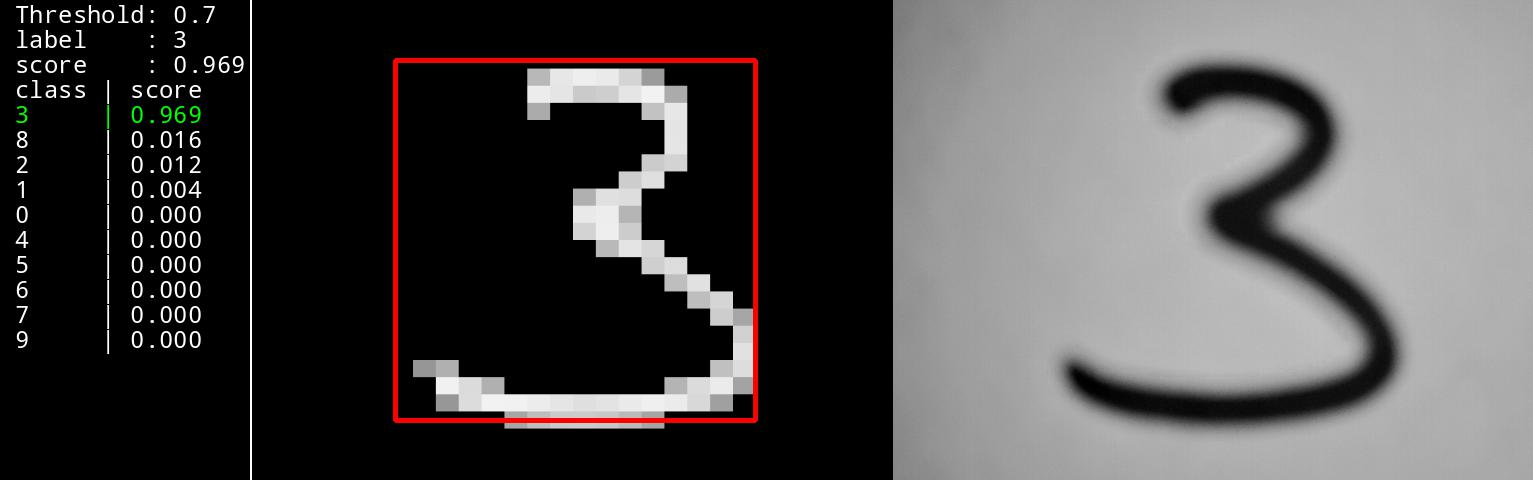

In [7]:

    
cap = cv2.VideoCapture(1)
try:
    while(True):

        ret, frame = cap.read()
        if ret:
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            to_classify = preprocessing(gray)
            
            prediction = predict(to_classify)
            to_classify = cv2.resize(to_classify, (gray.shape[1],gray.shape[0]) , interpolation = cv2.INTER_AREA)
            
            
            img2show = np.concatenate((to_classify,gray),axis=1)
            x,y = frame.shape[:2]

            
            # This rectangle is for orientation purpose only
            
            leftpt = -180
            rightpt = 180
            rectangle = ([leftpt+255+y//2,leftpt+x//2],(rightpt+255+y//2,rightpt+x//2))
            img2show = score2img(img2show,prediction)
            img2show = cv2.rectangle(img2show,tuple(rectangle[0]),tuple(rectangle[1]),(255,0,0),3)

            show_image(img2show)


except ValueError as e:
    traceback.print_exc()
except AttributeError as e:
    traceback.print_exc()
except TypeError as e:
    traceback.print_exc()
except OSError as e:
    traceback.print_exc()
except KeyboardInterrupt:
    pass
# When everything done, release the capture
cap.release()